# TODO：概要

# ライブラリのインポート

In [1]:
import os
import json
import datetime
import zoneinfo

import requests

from dotenv import load_dotenv, find_dotenv

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    ListSortOrder,
    CodeInterpreterTool,
    FunctionTool,
    ToolSet,
)
from IPython.display import Image, display

# 環境変数の取得

In [2]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")

# クライアントの初期化

In [3]:
# AI Project Client を初期化
project_client = AIProjectClient(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# AgentClient の作成
agents_client = project_client.agents

# ユーティリティ関数

In [4]:
def agent_run_outputs(thread_id, agents_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")
        
        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))

# ツールの定義

## Code Interpreter

In [5]:
# Code Interpreter ツールの定義
codeinterpreter = CodeInterpreterTool()

## カスタム関数

In [6]:
def get_prefecture_location(prefecture: str) -> str:
    """
    都道府県名から緯度・経度を取得します。都道府県一覧・座標は変更しません。

    :param prefecture (str): 都道府県名（例: "東京都"）
    :rtype: str

    :return: {"latitude": ..., "longitude": ...} 形式のJSON文字列。見つからなければ {"latitude": null, "longitude": null}
    :rtype: str
    """
    json_path ="../input_data/prefecture_locations.json"
    with open(json_path, "r", encoding="utf-8") as f:
        PREFECTURE_LOCATIONS = json.load(f)
        
    loc = PREFECTURE_LOCATIONS.get(prefecture)
    if loc:
        return json.dumps({"latitude": loc[0], "longitude": loc[1]})
    else:
        return json.dumps({"latitude": None, "longitude": None})


def get_current_time_jst() -> str:
    """
    日本標準時（JST, UTC+9）の今日の日付を "YYYY-MM-DD" 形式の文字列で返します。日時情報は変更しません。

    :rtype: str

    :return: 今日の日付（"YYYY-MM-DD" 形式の文字列）
    :rtype: str
    """
    jst = zoneinfo.ZoneInfo("Asia/Tokyo")
    now = datetime.datetime.now(jst)
    return now.strftime("%Y-%m-%d")


def get_temperature(latitude: float, longitude: float, date: str) -> str:
    """
    指定した緯度・経度と日付に基づき、Open-Meteo APIで該当日の平均気温（摂氏）を返します。
    外部サービスのみ参照し、情報は変更しません。

    :param latitude (float): 緯度
    :param longitude (float): 経度
    :param date (str): 日付（"YYYY-MM-DD" 形式）
    :rtype: str

    :return: 指定日の平均気温（摂氏）をJSON文字列で返します。データがなければ {"temperature": null}。
    :rtype: str
    """
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={latitude}&longitude={longitude}"
        f"&start_date={date}&end_date={date}"
        "&daily=temperature_2m_mean"
        "&timezone=Asia%2FTokyo"
    )
    resp = requests.get(url, timeout=5)
    resp.raise_for_status()
    data = resp.json()
    temps = data.get("daily", {}).get("temperature_2m_mean", [])
    value = temps[0] if temps else None
    return json.dumps({"temperature": value})


## Toolset に格納

In [7]:
# Toolset の作成＆関数の追加
toolset = ToolSet()

# Code Interpreter ツールを追加
toolset.add(codeinterpreter)

# カスタム関数ツールの定義
functions = FunctionTool(functions={get_prefecture_location, get_current_time_jst, get_temperature})
toolset.add(functions)

# エージェントで関数を自動的に呼び出すように設定
agents_client.enable_auto_function_calls(functions)

# エージェントの作成

In [8]:
code_interpreter_agent = agents_client.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたは日本国内の気温や地理情報に答えたり、計算や図表の出力に特化したアシスタントです。"
        "利用可能なツールを確認し、必要に応じて使用してください。"    
        "なお、グラフを描画する際は日本語が文字化けするため、ラベルやタイトルは英語で出力してください。"    
    ),
    description=(
        "Code Interpreter を利用して、計算や図表の出力に特化した分析アシスタントです。"
    ),
    tools=toolset.definitions,
)
print(f"Created Agent. AGENT_ID: {code_interpreter_agent.id}")


Created Agent. AGENT_ID: asst_BCUSg2MD4dWVlfuATOeUG6gx


# スレッドの作成

In [9]:
# Thread の作成
thread = agents_client.threads.create()
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: thread_S7Rr3P4F7NYrkP1h2SXPtaDS


# ユーザーメッセージの追加

In [10]:
user_message_01= (
    "過去5日間の東京の平均気温を調べてください。"
    "また、それをグラフで出力してください。"
)

message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=user_message_01,
)

print(f"Added Message. MESSAGE_ID: {message.id}")

Added Message. MESSAGE_ID: msg_TMgtLvF9pOHVS2FhHJm5yMt8


# Run の実行

USER: 過去5日間の東京の平均気温を調べてください。また、それをグラフで出力してください。
ASSISTANT: 過去5日間（2025年7月24日～28日）の東京都の平均気温は以下の通りです。

- 7月24日：28.0℃
- 7月25日：28.5℃
- 7月26日：28.8℃
- 7月27日：28.6℃
- 7月28日：28.6℃

上記データをグラフにしました。ご確認ください。
Saved image: assistant-D5jg66NfSwP2mLAiMLobmn_image_file.png


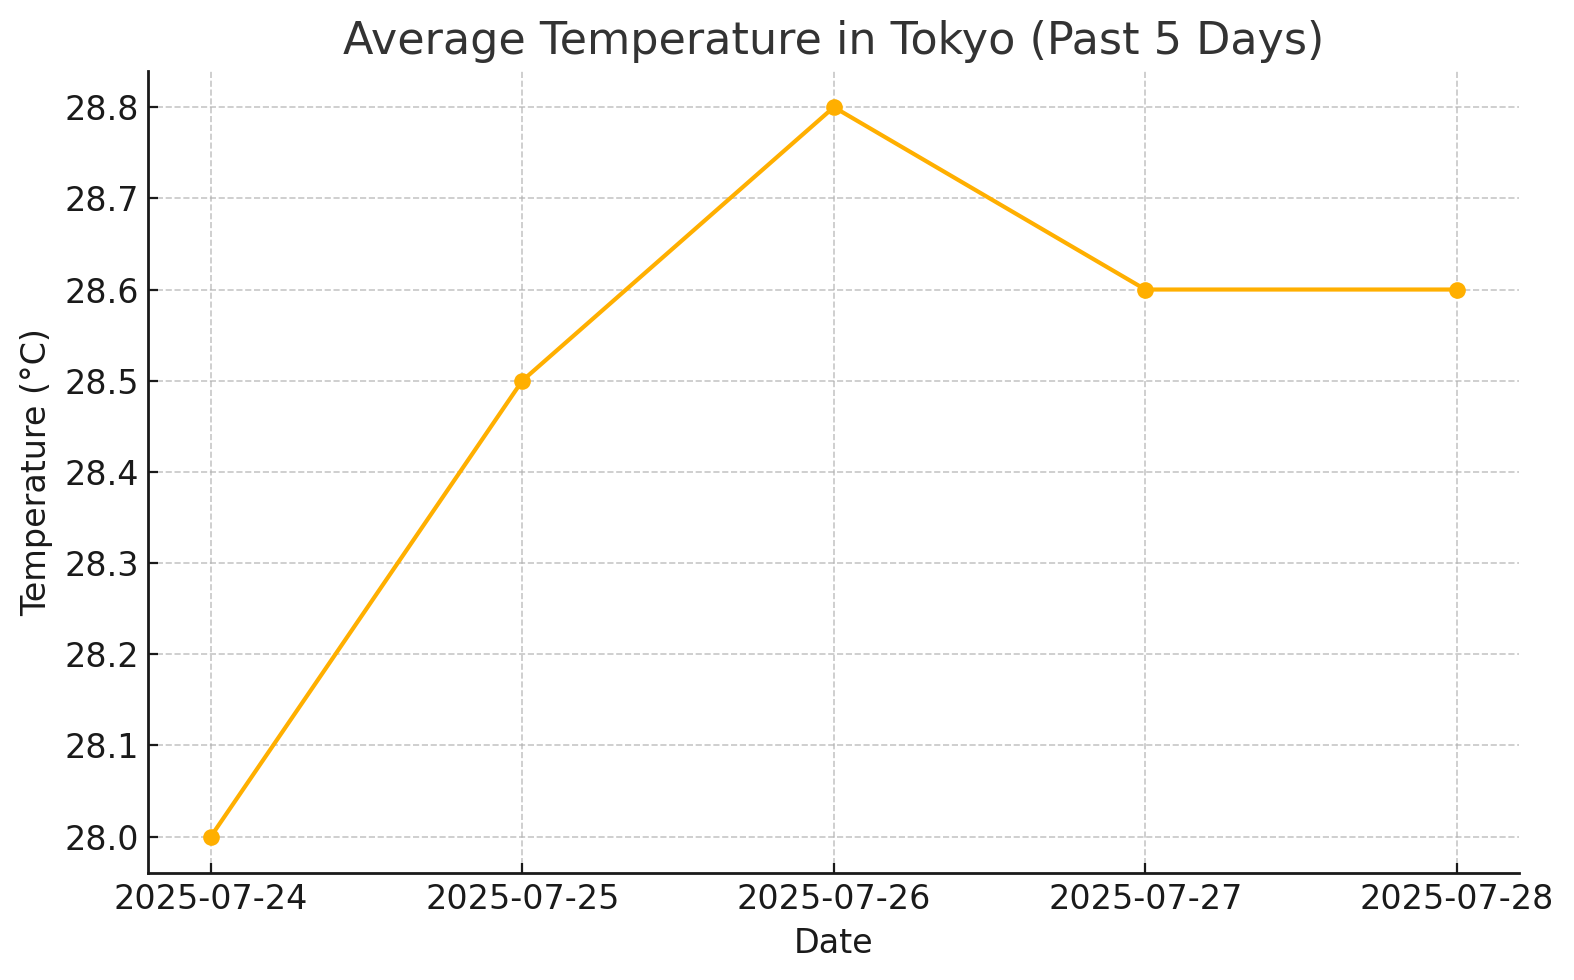

In [11]:
run = agents_client.runs.create_and_process(
    thread_id=thread.id,
    agent_id=code_interpreter_agent.id
)

if run.status == "failed":
    print(f"Run failed: {run.last_error}")
else:
    agent_run_outputs(thread.id, agents_client)

※ ここで、Azure AI Foundry 上の Web UI からエージェントのトレースを確認してみよう。

# Agent ID を .env ファイルに保存
※ 今回作成したエージェントを、後続のハンズオン演習で使用するため永続化します。

In [12]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent.id

# .envファイルのパスを自動探索
env_path = find_dotenv() 
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_BCUSg2MD4dWVlfuATOeUG6gx" を追記しました。
